In [1]:
import cv2
import skimage
import matplotlib.pyplot as plt
import numpy as np
import skimage.segmentation
from skimage.segmentation import mark_boundaries
from skimage import color
from skimage.util import img_as_float
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
import math
from skimage.restoration import inpaint
import sys
print(sys.path)
sys.path.insert(0,'/usr/bin/python')
print(sys.executable)
from cv2.ximgproc import guidedFilter
%matplotlib inline

['', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/home/shyamgopal/.local/lib/python3.6/site-packages', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/home/shyamgopal/.local/lib/python3.6/site-packages/IPython/extensions', '/home/shyamgopal/.ipython']
/usr/bin/python3


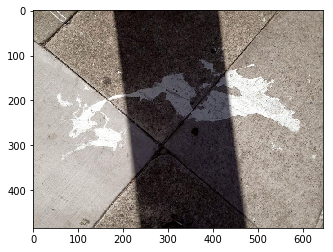

In [2]:
im1=skimage.io.imread('./SBU-shadow/SBUTrain4KRecoveredSmall/ShadowImages/lssd125.jpg')
im2=cv2.imread('./SBU-shadow/SBUTrain4KRecoveredSmall/ShadowMasks/lssd125.png',0)
plt.imshow(im1)

255 0
(484, 645, 3)
(484, 645)


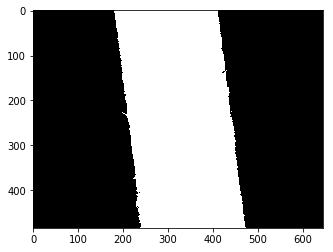

In [3]:
plt.imshow(im2,cmap='gray')
print(np.max(im1),np.min(im1))
print(im1.shape)
print(im2.shape)

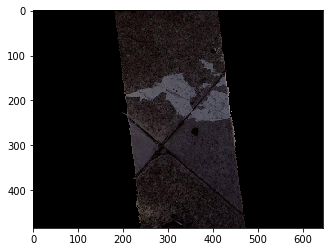

In [4]:
ins=np.zeros(im1.shape,dtype='uint8')
iss=np.zeros(im1.shape,dtype='uint8')
for i in range(len(im1)):
    for j in range(len(im1[i])):
        if im2[i][j]==0:
            ins[i][j]=np.array(im1[i][j])
            iss[i][j]=[0,0,0]
        else:
            ins[i][j]=[0,0,0]
            iss[i][j]=np.array(im1[i][j])
plt.imshow(iss)

11 13


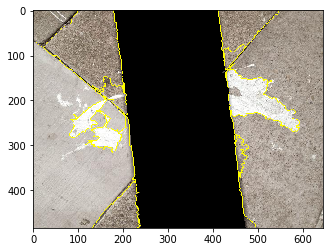

In [5]:
s1=skimage.segmentation.felzenszwalb(iss,scale=200.0,min_size=1000)
s2=skimage.segmentation.felzenszwalb(ins,scale=200.0,min_size=1000)
print(np.max(s1),np.max(s2))
plt.imshow(mark_boundaries(ins,s2))

6


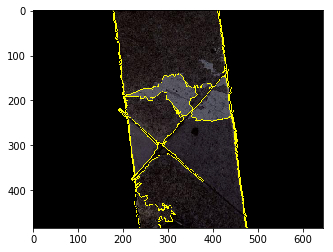

In [6]:
print(s1[200][400])
plt.imshow(mark_boundaries(iss,s1))

In [7]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    #print(feats.shape)
    image=skimage.color.rgb2gray(image)
    for k, kernel in enumerate(kernels):
        #print(kernel.shape)
        filtered = ndi.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats.flatten()
    return feats

kernels = []
for theta in range(3):
    theta = theta / 6. * np.pi
    for sigma in (1, 3):
        for frequency in (0.05, 0.25):
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))

            kernels.append(kernel)
print(len(kernels))
def dist(x1,x2,x3):
    cost=0.0
    #print(x1,x2)
    for i in range(len(x1)):
        cost+=abs((x1[i]-x2[i])/(x3[i]))
    return cost

12


In [8]:
#print(im1.shape)
img_feats=compute_feats(im1,kernels)
print("Img feats done")
mapping={}
dists=[np.inf for i in range(np.max(s1)+1)]

        
for i in range(np.max(s1)+1):
    print(i)
    m1= s1==i
    #minx,miny,maxx,maxy=5000,5000,0,0
    is_background=False
    outx,outy=np.nonzero(m1)
    minx=min(outx)
    maxx=max(outx)
    miny=min(outy)
    maxy=max(outy)
    meanx=np.mean(np.array(outx))
    meany=np.mean(np.array(outy))
    
    for it1 in range(len(outx)):
        if im2[outx[it1]][outy[it1]]==0:
            #print(outx[it1],outy[it1],im2[outx[it1]][outy[it1]])
            is_background=True
            break

    fts=compute_feats(im1[minx:maxx+1,miny:maxy+1,:],kernels)
    cur_dist=np.inf
    dsts=[]
    spacedts=[]
    for j in range(np.max(s2)+1):
        m2= s2==j
        #minx,miny,maxx,maxy=5000,5000,0,0
        is_foreground=False
        outxx,outyy=np.nonzero(m2)
        #print(outx,outy)
        minx=min(outxx)
        maxx=max(outxx)
        miny=min(outyy)
        maxy=max(outyy)
        mx=np.mean(np.array(outxx))
        my=np.mean(np.array(outyy))
        cnt=0
        tot=0
        for it2 in range(len(outxx)):
            if im2[outxx[it2]][outyy[it2]]>0:
                cnt+=1
            tot+=1
        if tot/2.0 < cnt:
            is_foreground=True
        if is_foreground:
            print(j,"is background")
            continue
        litfts=compute_feats(im1[minx:maxx+1,miny:maxy+1,:],kernels)
        
        space_cost= math.sqrt((meanx-mx)**2 + (meany-my)**2)
        dsts.append(dist(litfts,fts,img_feats))
        #spacedts.append(space_cost)
        #print("Distance",i,j,dist(fts,litfts,img_feats))
        if dist(fts,litfts,img_feats)<dists[i]:
            dists[i]=dist(fts,litfts,img_feats)
            print("Distance",i,j,dist(fts,litfts,img_feats))
            mapping[i]=j
    mapping[i]=np.argmin(dsts)
    #ind1 = np.argpartition(np.array(dsts), -10)[-10:]
    #ind2 = np.argpartition(np.array(dsts), -10)[-10:]
    
        
        
        
        
    

Img feats done
0
Distance 0 0 9.442437332562339
Distance 0 1 7.271635503137226
2 is background
Distance 0 4 4.308944331666083
Distance 0 5 3.6134157198445314
1
Distance 1 0 17.147960150192514
Distance 1 1 12.80144857396992
2 is background
2
Distance 2 0 14.211222587629006
2 is background
3
Distance 3 0 17.457288799520416
Distance 3 1 12.720178996946693
2 is background
Distance 3 8 11.558911520089115
4
Distance 4 0 5.910111046568696
Distance 4 1 4.575754410352356
2 is background
Distance 4 4 2.2521777267608516
5
Distance 5 0 12.798428587021338
2 is background
6
Distance 6 0 18.52445840064006
Distance 6 1 13.787348598066338
2 is background
Distance 6 8 13.532631354019708
Distance 6 13 13.207583834059845
7
Distance 7 0 12.739442139730485
2 is background
8
Distance 8 0 15.569461372339383
Distance 8 1 11.098451860406229
2 is background
9
Distance 9 0 14.507172143851015
2 is background
Distance 9 4 13.831128222438245
10
Distance 10 0 19.5596522507862
Distance 10 1 14.822542448212467
2 is bac

In [481]:
mapping

{0: 4, 1: 1, 2: 0, 3: 7, 4: 3, 5: 0, 6: 12, 7: 0, 8: 1, 9: 3, 10: 11, 11: 0}

0 483 411 476
[ 6.85070114e-02  7.43504965e-03  2.09429633e-02  9.04621681e-04
  4.62126241e-02  3.04916586e-03  6.89320951e-05  3.25343195e-05
  6.85074673e-02  7.42421810e-03  2.09652450e-02  8.34260243e-04
  4.63937030e-02  2.94009286e-03 -1.21518730e-05  7.34432592e-06
  6.85074673e-02  7.40790887e-03  2.09652450e-02  7.66877988e-04
  4.63937030e-02  2.77929545e-03 -1.21518730e-05  6.30603098e-06]


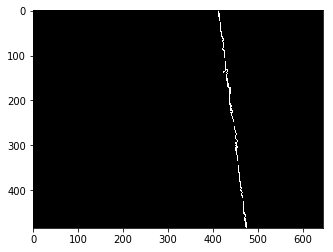

In [153]:
m1= (s1==3)
plt.imshow(m1,cmap='gray')
outx,outy=np.nonzero(m1)
minx=min(outx)
maxx=max(outx)
maxy=max(outy)
miny=min(outy)
print(minx,maxx,miny,maxy)
narr=iss[minx:maxx+1,miny:maxy+1,:]
outs=compute_feats(narr,kernels)
print(outs)

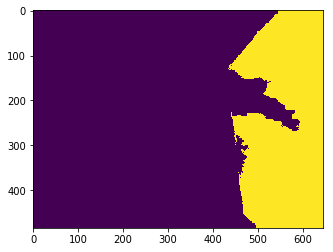

In [156]:
m1= s2==4
plt.imshow(m1)
outx,outy=np.nonzero(m1)
minx=min(outx)
maxx=max(outx)
maxy=max(outy)
miny=min(outy)
#print(minx,maxx,miny,maxy)
narr=ins[minx:maxx+1,miny:maxy+1,:]
out=compute_feats(narr,kernels)
##print(dist(out,outs,img_feats))

In [157]:
mapping[5]=7
mapping[6]=7
mapping[10]=5
mapping[2]=3
mapping[9]=4
mapping[1]=1
mapping[3]=4

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


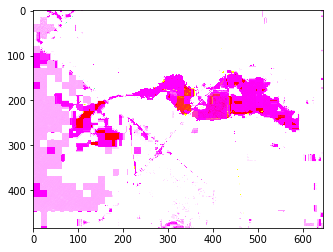

In [158]:
out_img=np.zeros(im1.shape,dtype='float64')
copy=np.array(im1,dtype='float64')
copy/=255.0
lab=skimage.color.rgb2lab(copy)
#lab=np.array(copy)
d1=[[] for  i in range(np.max(s1)+1)]
d2=[[] for  i in range(np.max(s2)+1)]
mean1=[[0.0,0.0,0.0] for i in range(np.max(s1)+1)]
mean2=[[0.0,0.0,0.0] for i in range(np.max(s2)+1)]
sig1=[[0.0,0.0,0.0] for i in range(np.max(s1)+1)]
sig2=[[0.0,0.0,0.0] for i in range(np.max(s2)+1)]
for i in range(np.max(s1)+1):
    m1= s1==i
    x1,y1=np.nonzero(m1)
    t1=[]
    t2=[]
    t3=[]
    for it1 in range(len(x1)):
        val=[lab[x1[it1]][y1[it1]][0],lab[x1[it1]][y1[it1]][1],lab[x1[it1]][y1[it1]][2]]
        d1[i].append(val)
        t1.append(val[0])
        t2.append(val[1])
        t3.append(val[2])
    t1=np.array(t1)
    t2=np.array(t2)
    t3=np.array(t3)
    mean1[i]=list([np.mean(t1),np.mean(t2),np.mean(t3)])
    sig1[i]=list([np.std(t1),np.std(t2),np.std(t3)])
    

for i in range(np.max(s2)+1):
    m1= s2==i
    x1,y1=np.nonzero(m1)
    t1=[]
    t2=[]
    t3=[]
    for it1 in range(len(x1)):
        val=[lab[x1[it1]][y1[it1]][0],lab[x1[it1]][y1[it1]][1],lab[x1[it1]][y1[it1]][2]]
        d2[i].append(val)
        t1.append(val[0])
        t2.append(val[1])
        t3.append(val[2])
    t1=np.array(t1)
    t2=np.array(t2)
    t3=np.array(t3)
    mean2[i]=list([np.mean(t1),np.mean(t2),np.mean(t3)])
    sig2[i]=list([np.std(t1),np.std(t2),np.std(t3)])

    
    
    
for i in range(len(im1)):
    print(i)
    for j in range(len(im1[i])):
        #print(i,j)
        if im2[i][j]>0:
            l1=s1[i][j]
            l2=mapping[l1]
            m1= s1==l1
            m2= s2==l2
            x1,y1=np.nonzero(m1)
            x2,y2=np.nonzero(m2)
            sigs=[0.0,0.0,0.0]
            Ak_avg=[0,0,0]

            #sig1=[np.std(np.array(d1[l1][0])),np.std(np.array(d1[l1][1])),np.std(np.array(d1[l1][3]))]
            #sig2=[np.std(np.array(d2[l2][0])),np.std(np.array(d2[l2][2])),np.std(np.array(d2[l2][3]))]
            sigs=[sig2[l2][0]/sig1[l1][0],sig2[l2][1]/sig1[l1][1],sig2[l2][2]/sig1[l1][2]]

            v1=mean2[l2][0]-(sigs[0]*mean1[l1][0])
            v2=mean2[l2][1]-(sigs[1]*mean1[l1][1])
            v3=mean2[l2][2]-(sigs[2]*mean1[l1][2])
            Ak_avg=[v1,v2,v3]
            #print(Ak_avg)
            Ak=[(Ak_avg[0]*lab[i][j][0])/mean1[l1][0],(Ak_avg[1]*lab[i][j][1])/mean1[l1][1],(Ak_avg[2]*lab[i][j][2])/mean1[l1][2]]
            #print(Ak)
            out_img[i][j]=[sigs[0]*lab[i][j][0]+Ak_avg[0],sigs[1]*lab[i][j][1]+Ak_avg[1],sigs[2]*lab[i][j][2]+Ak_avg[2]]
        else:
            out_img[i][j]=np.array(lab[i][j])
#fin_out=skimage.color.lab2rgb(out_img)
plt.imshow(out_img)
            

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


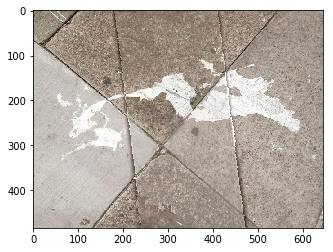

In [159]:
rgb=skimage.color.lab2rgb(out_img)
plt.imshow(rgb)
skimage.io.imsave('out1.png',rgb)

1197.774648846178


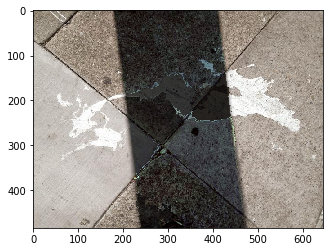

In [251]:
print(np.max(out_img))
imz=np.array(out_img,dtype='float64')/np.max(out_img)
#fin_out=skimage.color.lab2rgb(imz)
for i in range(len(im1)):
    for j in range(len(im1[i])):
        if im2[i][j]==0:
            imz[i][j]=np.array(im1[i][j])/255.0
plt.imshow(imz)

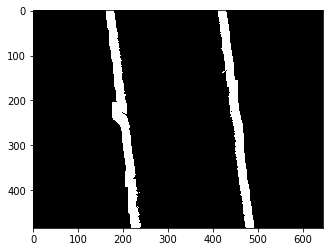

In [248]:
selem=[[1 for i in range(35)] for j in range(35)]
im3=skimage.morphology.binary_dilation(im2,selem)
im3=np.array(im3,dtype='uint8')
for i in range(len(im2)):
    for j in range(len(im2[i])):
        if im3[i][j]>0 and im2[i][j]==0:
            im3[i][j]=1
        if im3[i][j]>0 and im2[i][j]>0:
            im3[i][j]=0
plt.imshow(im3,cmap='gray')
im4=skimage.morphology.binary_erosion(im2,selem)
im5=np.zeros(im2.shape)
for i in range(len(im2)):
    for j in range(len(im2[i])):
        if im2[i][j]>0 and im4[i][j]==0:
            im5[i][j]=1
phis=np.array(im5)
phib=np.array(im3)

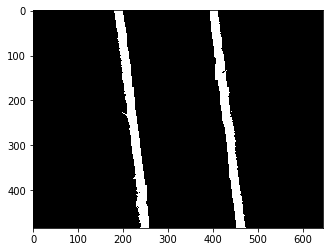

In [249]:
plt.imshow(im5,cmap='gray')

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


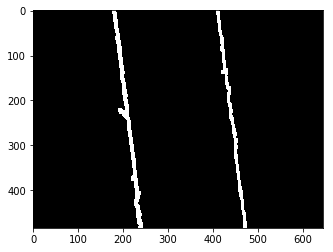

In [250]:
selem=[[1 for i in range(8)] for j in range(8)]
im3=skimage.morphology.binary_dilation(im2,selem)
im3=np.array(im3,dtype='uint8')
im4=skimage.morphology.binary_erosion(im2,selem)
im4=np.array(im4,dtype='uint8')
boundaries=np.zeros(im2.shape)
for i in range(len(im2)):
    for j in range(len(im2[i])):
        if im3[i][j]>0 and im4[i][j]==0:
            boundaries[i][j]=1
        

#image_result = inpaint.inpaint_biharmonic(rgb, im3,multichannel=True)
plt.imshow(boundaries,cmap='gray')
skimage.io.imsave('mask.png',boundaries)

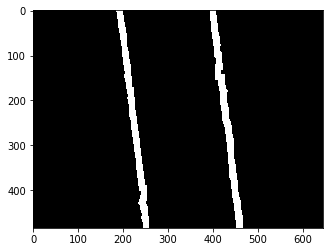

In [251]:
for i in range(len(im2)):
    for j in range(len(im2[i])):
        if boundaries[i][j]>0:
            phis[i][j]=0
            phib[i][j]=0
plt.imshow(phis,cmap='gray')

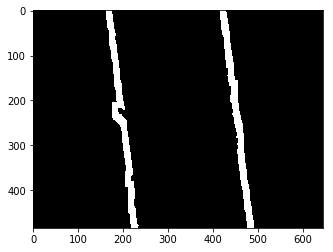

In [252]:
plt.imshow(phib,cmap='gray')

In [255]:
copy_im1=np.array(im1,dtype='float64')
copy_im1/=255.0
#copy_im1=skimage.color.rgb2lab(copy_im1)
#h=[0.0,0.0,0.0]
Ak_avg=[0.0,0.0,0.0]
x1,y1=np.where(phis>0)
x2,y2=np.where(phib>0)
d1=[]
t1=[]
t2=[]
t3=[]
d2=[]

for i in range(len(x1)):
    d1.append(copy_im1[x1[i]][y1[i]])
    t1.append(copy_im1[x1[i]][y1[i]][0])
    t2.append(copy_im1[x1[i]][y1[i]][1])
    t3.append(copy_im1[x1[i]][y1[i]][2])
mean1=[np.mean(np.array(t1)),np.mean(np.array(t2)),np.mean(np.array(t3))]
std1=[np.std(np.array(t1)),np.std(np.array(t2)),np.std(np.array(t3))]
t1,t2,t3=[],[],[]
for i in range(len(x2)):
    d2.append(copy_im1[x2[i]][y2[i]])
    t1.append(copy_im1[x2[i]][y2[i]][0])
    t2.append(copy_im1[x2[i]][y2[i]][1])
    t3.append(copy_im1[x2[i]][y2[i]][2])
mean2=[np.mean(np.array(t1)),np.mean(np.array(t2)),np.mean(np.array(t3))]
std2=[np.std(np.array(t1)),np.std(np.array(t2)),np.std(np.array(t3))]
#h=[(mean2[i]-mean1[i])/(1.0*mean1[i]) for i in range(3)]
gamma=[std2[i]/std1[i] for i in range(3)]
Ak_avg=[mean2[i]-gamma[i]*mean1[i] for i in range(3)]
print(mean1)
print(mean2)
print(gamma)
print(Ak_avg)
#print(h)

[0.16939184895475062, 0.14144873987015455, 0.15635803803646417]
[0.6788015050013766, 0.6343741396714693, 0.5956267270298655]
[1.935223741584683, 1.9892727791360094, 1.8974186171537293]
[0.35099037727321664, 0.3529940118046805, 0.29895007471784746]


In [254]:
copy_im1=np.array(im1,dtype='float64')
copy_im1/=255.0
copy_im1=skimage.color.rgb2lab(copy_im1)
h=[0.0,0.0,0.0]
Ak_avg=[0.0,0.0,0.0]
x1,y1=np.where(phis>0)
x2,y2=np.where(phib>0)
d1=[]
t1=[]
t2=[]
t3=[]
d2=[]

for i in range(len(x1)):
    d1.append(copy_im1[x1[i]][y1[i]])
    t1.append(copy_im1[x1[i]][y1[i]][0])
    t2.append(copy_im1[x1[i]][y1[i]][1])
    t3.append(copy_im1[x1[i]][y1[i]][2])
mean1=[np.mean(np.array(t1)),np.mean(np.array(t2)),np.mean(np.array(t3))]
#std1=[np.std(np.array(t1)),np.std(np.array(t2)),np.std(np.array(t3))]
t1,t2,t3=[],[],[]
for i in range(len(x2)):
    d2.append(copy_im1[x2[i]][y2[i]])
    t1.append(copy_im1[x2[i]][y2[i]][0])
    t2.append(copy_im1[x2[i]][y2[i]][1])
    t3.append(copy_im1[x2[i]][y2[i]][2])
mean2=[np.mean(np.array(t1)),np.mean(np.array(t2)),np.mean(np.array(t3))]
#std2=[np.std(np.array(t1)),np.std(np.array(t2)),np.std(np.array(t3))]
h=(mean2[0]-mean1[0])/(1.0*mean1[0])
#gamma=[std2[i]/std1[i] for i in range(3)]
#Ak_avg=[mean2[i]-gamma[i]*mean1[i] for i in range(3)]
print(h)

3.4540171625217417


In [260]:
matte=np.zeros(im2.shape,dtype='float64')
matte= guidedFilter(im1,im2,15,100.0,None)
tmp=matte-im2
print(np.min(matte),np.max(matte))
#image_result = inpaint.inpaint_biharmonic(rgb,tmp,multichannel=True)
#plt.imshow(image_result,cmap='gray')

0 255


0.0 1.0 0.0
3.4540171625217417


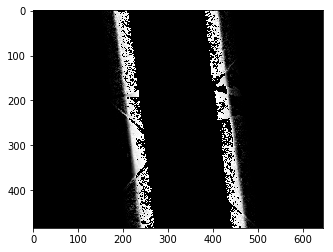

In [261]:
m1=np.zeros(matte.shape)
copy_matte=np.zeros(im2.shape,dtype='float64')
copy_matte=matte/255.0

print(np.min(copy_matte),np.max(copy_matte),np.median(copy_matte))
for i in range(len(m1)):
    for j in range(len(m1[i])):
        if 0<copy_matte[i][j]<1:
            m1[i][j]=copy_matte[i][j]
plt.imshow(m1,cmap='gray')
print(h)

3.400711409284357


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.400711409284357


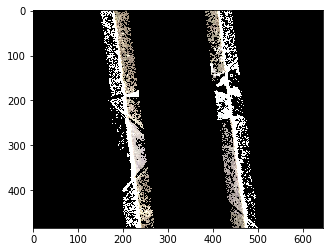

In [266]:
ibf=np.zeros(im1.shape,dtype='float64')
copy_im1=np.array(im1,dtype='float64')
copy_im1/=255.0
for i in range(len(im2)):
    for j in range(len(im2[i])):
        if 0 < copy_matte[i][j]<1:
            alpha=copy_matte[i][j]
            #print(alpha)
            Ak=[Ak_avg[it]*((1-alpha)*h +1) for it in range(3)]
            #print(Ak)
            ibf[i][j]=np.array([Ak[it]+gamma[it]*copy_im1[i][j][it] for it in range(3) ])
            #print(Ak,ibf[i][j])
        else:
            pass
            #ibf[i][j]=rgb[i][j]

print(np.max(ibf))
#ibf=skimage.color.lab2rgb(ibf)
#ibf/=1.5
#plt.imshow(ibf)
#imtest=ibf>0.5
imtest=np.zeros(im2.shape,dtype='uint8')

for i in range(len(ibf)):
    for j in range(len(ibf[i])):
        if ibf[i][j][0]>0:
            imtest[i][j]=255
        else:
            imtest[i][j]=0
plt.imshow(ibf)
print(np.max(ibf))
#skimage.io.imsave('mask.png',imtest)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


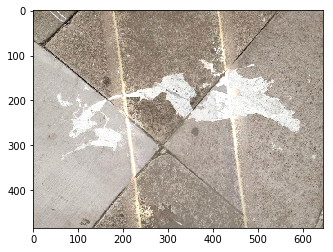

In [267]:
def p(alpha):
    a=0.2
    b=1.15
    return a*(alpha*alpha)+b

fin_img=np.zeros(im1.shape)
for i in range(len(im1)):
    for j in range(len(im1[i])):
        if 0<copy_matte[i][j]<1:
            alpha=copy_matte[i][j]
            #print(alpha)
            fin_img[i][j]=[ibf[i][j][it]*alpha+copy_im1[i][j][it]*(1-alpha)*p(alpha) for it in range(3)]
        else:
            fin_img[i][j]=np.array(rgb[i][j])
plt.imshow(fin_img)
        

/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


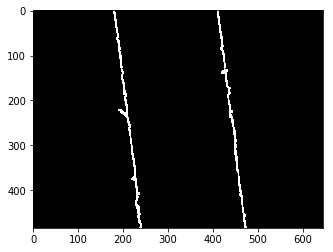

In [137]:
selem=[[1 for i in range(5)] for j in range(5)]
im3=skimage.morphology.binary_dilation(im2,selem)
im3=np.array(im3,dtype='uint8')
im4=skimage.morphology.binary_erosion(im2,selem)
im4=np.array(im4,dtype='uint8')
boundaries=np.zeros(im2.shape)
for i in range(len(im2)):
    for j in range(len(im2[i])):
        if im3[i][j]>0 and im4[i][j]==0:
            boundaries[i][j]=1
        

#image_result = inpaint.inpaint_biharmonic(rgb, im3,multichannel=True)
plt.imshow(boundaries,cmap='gray')
skimage.io.imsave('mask.png',boundaries)

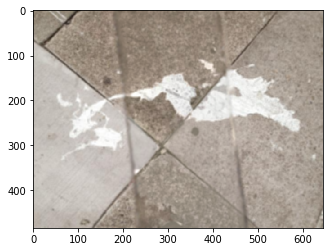

In [135]:

kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(image_result,-1,kernel)
plt.imshow(dst)